In [1]:
!pip install psycopg2-binary pycbrf pytelegrambotapi schedule

     |████████████████████████████████| 3.0 MB 26.9 MB/s 
     |████████████████████████████████| 147 kB 44.3 MB/s 
  Created wheel for pytelegrambotapi: filename=pyTelegramBotAPI-4.4.0-py3-none-any.whl size=128152 sha256=c72e7a740416639d79ed12b4616fec106340c836b26a4e68faffb63482623d90
  Stored in directory: /root/.cache/pip/wheels/1e/6d/ff/435b12799b8212017f08dbbfdb7a1e5174d72d20fb7c0f4703
Successfully built pytelegrambotapi


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
import os

import numpy as np
import pandas as pd

import psycopg2 # для подключения к БД
from pycbrf import ExchangeRates, Banks  # для получения курсов валют
import telebot  # для работы с телеграм ботом

import schedule, time

import six
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/career_factory/careerfactory_2022_1'
sys.path.append(os.path.abspath(path))

In [5]:
from postgresql_secret import pg_secret              # извлечь данные для подключения к БД из postgresql_secret.py
from telegram_secret import telegram_token, user_id  # извлечь токен телеграм бота и id пользователя из telegram_secret.py

Содержимое импортированного файла `postgresql_secret.py`:

```
pg_secret = {
    "db_host": "178.62.242.91",
    "db_name": "quest-db",
    "db_password": "ZI6MVnmi",
    "db_port": "5433",
    "db_user": "rouser"
}
```

Содержимое импортированного файла `telegram_secret.py`:

```
telegram_token = 'xxxxxxxxxxx:yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy'
user_id = 000000000
```

In [6]:
connection = psycopg2.connect(
                             database = pg_secret['db_name'],
                             user =     pg_secret['db_user'],
                             password = pg_secret['db_password'],
                             host =     pg_secret['db_host'],
                             port =     pg_secret['db_port'],
                             )

In [7]:
cursor = connection.cursor()

In [8]:
bot = telebot.TeleBot(telegram_token)

# Задание 1 «Отчёт о продажах в Телеграм»



*Задание от Михаила Морозова - ex Chief Analytics Officer Skyeng, со-автор профессии "Аналитик данных" в Skypro. У него много видео с выступлениями и рекомендациями в Youtube.*

Вы работаете аналитиком в стартапе в области обучения взрослых английскому языку. Компания растет быстро, целый штат маркетологов и продактов придумывает новые механики привлечения пользователей, улучшая коммерческие продукты.

Ещё есть отдел продаж. В нём сотрудники звонят потенциальным клиентам и продают пакеты уроков. Только вот маркетинг не дружит с продажами и красивой сквозной аналитики у Руководителя отдела продаж нет. Нужно ему помочь.

Никакого централизованного DWH или сложного BI - у компании нет, но бизнесу точно нужны основные метрики, причем завтра. Данные об основных событиях CJM пользователя записываются в Postgres.

Руководитель отдела продаж просит вас каждый день присылать в его telegram метрики или графики. Они должны помочь ему понимать как идут дела в отделе, так сказать держать руку на пульсе.

Данные

Все таблицы с данными в PostgresSQL. Параметры для подключения:

database = "quest-db",  
user = "rouser",  
password = "ZI6MVnmi",  
host = "178.62.242.91",  
port = "5433"

**Таблицы**:

- events — таблица событий по пользователям и датам
- events_dict — таблица со списком событий их описанием
- payments — транзакции пользователей

Задачи

1. Выберите 3 метрики, которые помогут руководителю отдела продаж контролировать ситуацию ежедневно — всё ли идёт нормально. Объясните свой выбор.
2. Напишите Телеграм Бота (скрипт), который будет отправлять ежедневный отчёт по этим метрикам в Телеграм руководителю.
Чтобы показать, как работает бот вставьте его код в файл с ответом и прикрепите скриншот отправленного им сообщения, чтобы было видно от кого это. Под названием отправителя должно быть написано Бот, как на скриншоте ниже.

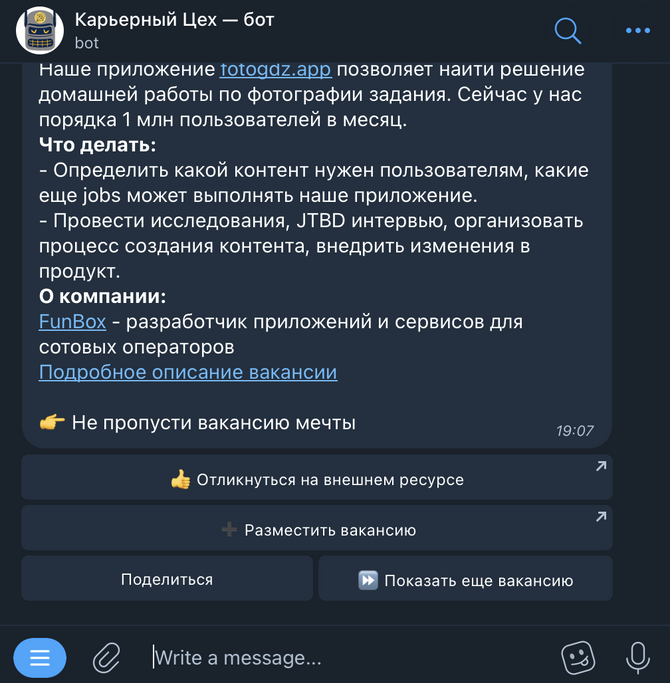

Рекомендации

- Бота можно развернуть на своём компьютере, сервер тут не нужен. Достаточно подписаться на Бота. Прислать сообщение - отчёт самому себе — сделать скриншот и вставить в документ.
- Токены для доступа к боту и пароли не безопасно размещать прямо в коде. Поэтому, обычно токены и пароли записывают в отдельный файл enviromental variables (файл с расширением .env), а кодом считывают их оттуда. [Статья о переменных окружения и создании файла с ними](https://dev.to/jakewitcher/using-env-files-for-environment-variables-in-python-applications-55a1) (на англ.)
Если не используете внешний файл, то уберите из кода пароли и токены.
- Статья «[Как собрать Телеграм-бота на Питоне за 30 минут](https://habr.com/ru/post/442800/)» поможет, если вы до этого не настраивали репортинг в Телеграм.

**Рекомендуемый объем решения — 2 страницы A4, минимальный размер шрифта 11 пунктов (можно больше).** Без учёта кода и скриншотов.

Лаконичный и короткий ответ, без лишних объяснений упрощает проверку. А хорошо проверенная работа → больше шанса на объективную оценку и выше место в рейтинге.

Все события — различные этапы CJM пользователя.

Стандартный CJM:
1.  пользователь оставляет Заявку
2. 1ая линия связывается с пользователем и назначает вводный урок (ВУ)
3. Проводится вводный урок(ВУ) на котором методист предлагает клиенту совершить оплату. 
4. Если клиент не оплатил на ВУ, после с ним связывается 2ая линия и предлагает оплатить обучение.

Но кроме стандартной воронки, мы экспериментируем, и стараемся улучшить нашу воронку, внедряя на разных этапах общение не по телефону, а через Whatsapp, или заменяя ВУ другим, более дешёвым с точки зрения прямых костов продуктом — ДУ (демонстрационный урок).

Ну и так как наш продукт только развивается, в действительности, CJM может быть сильно витиеватым:)

### Загрузка данных

#### events

In [9]:
query = "SELECT * FROM events"   # запрос к БД
cursor.execute(query)            # делаем запрос
result = cursor.fetchall()       # запрашиваем все строки, получаем результат в виде списка кортежей

result[:5]

[('317992', '6', '12380697', '2021-06-03 14:04:06'),
 ('317993', '6', '12337967', '2021-05-29 13:35:06'),
 ('317994', '6', '12340824', '2021-06-04 16:35:06'),
 ('317995', '6', '12342875', '2021-05-29 11:40:32'),
 ('317996', '6', '12453086', '2021-06-14 17:14:30')]

In [10]:
# имена колонок
cursor.description

(Column(name='pk', type_code=1043),
 Column(name='event_id', type_code=1043),
 Column(name='_user_id', type_code=1043),
 Column(name='happened_at', type_code=1043))

In [11]:
columns = []                     # В этот список будем сохранять названия колонок
for desc in cursor.description:  
    columns.append(desc[0])      # Названия колонок возьмем из первого элемента cursor.description

    
events = pd.DataFrame(result, columns=columns)  # Из списка кортежей сделаем датафрейм
events.shape

(361688, 4)

In [12]:
events.head(3)

,pk,event_id,_user_id,happened_at
0,317992,6,12380697,2021-06-03 14:04:06
1,317993,6,12337967,2021-05-29 13:35:06
2,317994,6,12340824,2021-06-04 16:35:06


In [ ]:
# сохранение датафрейма в csv
events.to_csv('/content/drive/MyDrive/Colab Notebooks/career_factory/careerfactory_2022_1/events.csv', index=False)

In [ ]:
events = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/career_factory/careerfactory_2022_1/events.csv', parse_dates=['happened_at'])
events.shape

(361688, 4)

In [17]:
# проверка на наличие пропущенных значений
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361688 entries, 0 to 361687
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   pk           361688 non-null  object
 1   event_id     361688 non-null  object
 2   _user_id     361688 non-null  object
 3   happened_at  361688 non-null  object
dtypes: object(4)
memory usage: 11.0+ MB


In [13]:
# проверка на наличие дубликатов
events.drop_duplicates().shape

(361688, 4)

In [14]:
# начальная и конечная даты наблюдений
events['happened_at'].agg(['min', 'max'])

min    2018-05-28 15:25:59
max    2022-03-14 17:43:58
Name: happened_at, dtype: object

In [16]:
# количество уникальных пользователей
events._user_id.nunique()

84306

In [23]:
events['happened_at'] = pd.to_datetime(events['happened_at'])
events['date'] = events['happened_at'].dt.normalize()
events['month'] = events['date'].astype('datetime64[M]')

In [24]:
events.groupby('month', as_index=False).agg({'_user_id': 'nunique'})

,month,_user_id
0,2018-05-01,1
1,2018-12-01,2
2,2019-01-01,1
3,2019-02-01,1
4,2019-06-01,1
5,2019-07-01,1
6,2019-08-01,1
7,2019-09-01,1
8,2019-10-01,1
9,2019-12-01,1


Количество уникальных пользователей с 2018-05-01 по 2021-04-01 не больше 6. Видимо это период тестирования продукта, а полноценный запуск состоялся с мая 2021 года.
В первые два месяца с момента запуска наблюдается самое большое количество уникальных пользователей, это может быть связано с масштабной рекламной кампанией.

#### events_dict

In [25]:
query = "SELECT * FROM events_dict"   # Запрос к БД
cursor.execute(query)                 # Сделаем запрос
result = cursor.fetchall()            # Запросим все строки, мы получим результат в виде списка кортежей

result[:5]

[('0', '0', 'student_created_order', '3', 'Создание заявки'),
 ('1', '497', 'student_booked_introlesson', '2', 'Назначение ВУ'),
 ('2', '934', 'student_pass_introlesson_succesfully', '7', 'Успешный ВУ'),
 ('3',
  '956',
  'firstline_operator_assigned_at_task',
  '8',
  'Назначение задачи на звонок 1Л'),
 ('4',
  '1007',
  'secondline_operator_assigned_at_task',
  '12',
  'Назначена задача на вторую линию')]

In [26]:
# имена колонок
cursor.description

(Column(name='pk', type_code=1043),
 Column(name='_index', type_code=1043),
 Column(name='_name', type_code=1043),
 Column(name='id', type_code=1043),
 Column(name='_description', type_code=1043))

In [27]:
columns = []                     # В этот список будем сохранять названия колонок
for desc in cursor.description:  
    columns.append(desc[0])      # Названия колонок возьмем из первого элемента cursor.description

    
events_dict = pd.DataFrame(result, columns=columns)  # Из списка кортежей сделаем датафрейм
events_dict.shape

(12, 5)

In [28]:
events_dict

,pk,_index,_name,id,_description
0,0,0,student_created_order,3,Создание заявки
1,1,497,student_booked_introlesson,2,Назначение ВУ
2,2,934,student_pass_introlesson_succesfully,7,Успешный ВУ
3,3,956,firstline_operator_assigned_at_task,8,Назначение задачи на звонок 1Л
4,4,1007,secondline_operator_assigned_at_task,12,Назначена задача на вторую линию
5,5,1227,student_answered_firstline_operator,4,Ученик ответил на звонок оператора 1л
6,6,1619,methodist_joined_introlesson,6,Выход МВУ на ВУ
7,7,1715,student_passed_demolesson,11,ДУ завершен
8,8,1801,student_answered_secondline_operator,9,Дозвон 2Л
9,9,2014,student_joined_demolesson,10,Переход на ДУ (ДУ начался)


In [29]:
events_dict.to_csv('/content/drive/MyDrive/Colab Notebooks/career_factory/careerfactory_2022_1/events_dict.csv', index=False)

In [ ]:
events_dict = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/career_factory/careerfactory_2022_1/events_dict.csv')
events_dict

,pk,_index,_name,id,_description
0,0,0,student_created_order,3,Создание заявки
1,1,497,student_booked_introlesson,2,Назначение ВУ
2,2,934,student_pass_introlesson_succesfully,7,Успешный ВУ
3,3,956,firstline_operator_assigned_at_task,8,Назначение задачи на звонок 1Л
4,4,1007,secondline_operator_assigned_at_task,12,Назначена задача на вторую линию
5,5,1227,student_answered_firstline_operator,4,Ученик ответил на звонок оператора 1л
6,6,1619,methodist_joined_introlesson,6,Выход МВУ на ВУ
7,7,1715,student_passed_demolesson,11,ДУ завершен
8,8,1801,student_answered_secondline_operator,9,Дозвон 2Л
9,9,2014,student_joined_demolesson,10,Переход на ДУ (ДУ начался)


В этом датафрейме хранится расшифровка событий из ранее загруженного датафрейма `events`.

#### payments

[Средние курсы валют за год](https://www.ruble24.ru/%D0%A7%D0%B8%D0%BB%D0%B8%D0%B9%D1%81%D0%BA%D0%BE%D0%B5-%D0%BF%D0%B5%D1%81%D0%BE/2021) - этот сайт использовался для получения информации по валютам, которые отсутствуют в библотеке `pycbrf`.

In [30]:
query = "SELECT * FROM payments"  # Запрос к БД
cursor.execute(query)             # Сделаем запрос
result = cursor.fetchall()        # Запросим все строки, мы получим результат в виде списка кортежей

result[:5]

[('0', '3807046', '2021-05-16 03:41:25', '12242732', 'RUB', '390.0', 'false'),
 ('1', '3807613', '2021-05-16 11:06:23', '12241834', 'RUB', '7980.0', 'false'),
 ('2',
  '3807673',
  '2021-05-16 11:33:06',
  '12241501',
  'RUB',
  '24880.0',
  'false'),
 ('3', '3810405', '2021-05-17 09:45:40', '12242141', 'RUB', '8520.0', 'false'),
 ('4',
  '3811432',
  '2021-05-17 13:35:35',
  '12251367',
  'RUB',
  '14360.0',
  'false')]

In [31]:
# имена колонок
cursor.description

(Column(name='pk', type_code=1043),
 Column(name='transaction_id', type_code=1043),
 Column(name='transaction_created_at', type_code=1043),
 Column(name='_user_id', type_code=1043),
 Column(name='currency', type_code=1043),
 Column(name='amount', type_code=1043),
 Column(name='is_gift', type_code=1043))

In [32]:
columns = []                     # В этот список будем сохранять названия колонок
for desc in cursor.description:  
    columns.append(desc[0])      # Названия колонок возьмем из первого элемента cursor.description

    
payments = pd.DataFrame(result, columns=columns)  # Из списка кортежей сделаем датафрейм
payments.shape

(69803, 7)

In [33]:
payments.head(3)

,pk,transaction_id,transaction_created_at,_user_id,currency,amount,is_gift
0,0,3807046,2021-05-16 03:41:25,12242732,RUB,390.0,false
1,1,3807613,2021-05-16 11:06:23,12241834,RUB,7980.0,false
2,2,3807673,2021-05-16 11:33:06,12241501,RUB,24880.0,false


In [34]:
payments.to_csv('/content/drive/MyDrive/Colab Notebooks/career_factory/careerfactory_2022_1/payments.csv', index=False)

In [59]:
payments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/career_factory/careerfactory_2022_1/payments.csv', parse_dates=['transaction_created_at'])
payments = payments.rename(columns = {'_user_id': 'user_id'})
payments.shape

(69803, 7)

In [36]:
# перевод колонки в формат datetime
payments['transaction_created_at'] = pd.to_datetime(payments['transaction_created_at'])
# оставляем только дату
payments['transaction_created_at'] = payments['transaction_created_at'].dt.normalize()

In [37]:
payments.head(3)

,pk,transaction_id,transaction_created_at,_user_id,currency,amount,is_gift
0,0,3807046,2021-05-16,12242732,RUB,390.0,false
1,1,3807613,2021-05-16,12241834,RUB,7980.0,false
2,2,3807673,2021-05-16,12241501,RUB,24880.0,false


In [40]:
# начальная и конечная даты наблюдений
payments['transaction_created_at'].agg(['min', 'max'])

min   2021-05-15
max   2022-03-15
Name: transaction_created_at, dtype: datetime64[ns]

In [38]:
# проверка наличия дубликатов
payments.drop_duplicates().shape

(69803, 7)

In [39]:
# проверка наличия пропущенных значений
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69803 entries, 0 to 69802
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   pk                      69803 non-null  object        
 1   transaction_id          69803 non-null  object        
 2   transaction_created_at  69803 non-null  datetime64[ns]
 3   _user_id                69803 non-null  object        
 4   currency                69803 non-null  object        
 5   amount                  69803 non-null  object        
 6   is_gift                 69803 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 3.7+ MB


In [ ]:
# распределение по валютам, используемым для оплаты
payments.currency.value_counts()

RUB    61882
EUR     5220
USD     2142
PLN      447
GBP       30
UAH       25
KRW       21
CLP       18
PEN        8
JPY        7
MXN        2
UYU        1
Name: currency, dtype: int64

Валюты CLP, PEN, MXN, UYU отсутствуют в библиотеке `pycbrf`. Количество транзакций с использованием этих валют невелико, поэтому будем использовать среднегодовые курсы этих валют, чтобы перевести значение колонки `amount` в рубли.

Для всех остальных валют будем использовать курс ЦБ РФ на время проведения транзакций для перевода в рубли.

In [ ]:
def currency_dates_df(inp_currency):

  '''
  Перевод курсов валют в рубли на момент проведения транзакции
  '''

  df_dates = payments[payments.currency == inp_currency].transaction_created_at.dt.normalize().unique()
  df = pd.DataFrame({'transaction_date': df_dates})
  df['currency'] = inp_currency
  df['exchange_rate'] = df.transaction_date.apply(lambda x: float(ExchangeRates(x, locale_en=True)[inp_currency].value))
  return df

In [ ]:
# функция currency_dates_df работает медленно
# поэтому запустим ее один раз и результат сохраним в csv
# чтобы в последующем не требовалось запускать функцию снова

concat_df = pd.DataFrame()

for currency in ['EUR', 'GBP', 'PLN', 'USD', 'JPY', 'KRW', 'UAH']:
  tmp_df = currency_dates_df(currency)
  concat_df = pd.concat([concat_df, tmp_df])
concat_df.shape

(623, 3)

In [27]:
concat_df.head(3)

,transaction_date,currency,exchange_rate
0,2021-05-18,EUR,89.6584
1,2021-05-19,EUR,89.9057
2,2021-05-20,EUR,90.1006


In [ ]:
concat_df.to_csv('/content/drive/MyDrive/Colab Notebooks/career_factory/careerfactory_2022_1/concat_df.csv', index=False)

In [41]:
concat_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/career_factory/careerfactory_2022_1/concat_df.csv', parse_dates = ['transaction_date'])
concat_df.shape

(623, 3)

In [42]:
def exchange_rate_function(arr):

  '''
  Добавление курса валюты в датафрейм на момент проведения транзакции
  '''

  currency = arr[0]
  date = arr[1]

  # среднегодовые курсы валют, которые отсутствуют в pycbrf
  cur_dict = {
      'CLP': {2021 : 0.09734, 2022: 0.1150},
      'PEN': {2021 : 19.039, 2022: 24.452},
      'MXN': {2021 : 3.6347, 2022: 4.5174},
      'UYU': {2021 : 1.6923, 2022: 2.1462}
  }

  if currency in concat_df.currency.unique():
    return concat_df[(concat_df['transaction_date'] == date) & (concat_df['currency'] == currency)].iloc[0, 2]
  elif currency in cur_dict.keys():
    return cur_dict[currency][date.year]
  elif currency == 'RUB':
    return 1

  return 'unknown_currency'

In [45]:
# добавляем колонку exchange_rate - курс валюты на момент проведения транзакции
payments['exchange_rate'] = payments[['currency', 'transaction_created_at']].apply(exchange_rate_function, axis=1)  # [payments.currency == 'PEN']

In [50]:
# перевод формата колонки в float
payments['amount'] = payments['amount'].astype(float)

# добавляем колонку amount_rub - размер транзакции в рублях
payments['amount_rub'] = np.round(payments.amount * payments.exchange_rate, 2)

In [51]:
payments.head()

,pk,transaction_id,transaction_created_at,_user_id,currency,amount,is_gift,exchange_rate,amount_rub
0,0,3807046,2021-05-16,12242732,RUB,390.0,false,1.0,390.0
1,1,3807613,2021-05-16,12241834,RUB,7980.0,false,1.0,7980.0
2,2,3807673,2021-05-16,12241501,RUB,24880.0,false,1.0,24880.0
3,3,3810405,2021-05-17,12242141,RUB,8520.0,false,1.0,8520.0
4,4,3811432,2021-05-17,12251367,RUB,14360.0,false,1.0,14360.0


Теперь в датафрейме есть колонка с размеров транзакции в рублях.

### Выбор метрик

Нам нужны ежедневные метрики, поэтому выберем те, которые позволят отображать состояние продукта на текущий день:

1. **Дневная выручка** - смотрим как распределяется выручка за последние 7 дней, сравниваем ее с выручкой за аналогичные дни прошлой недели и со средней выручкой за аналогичные дни последних четырех недель. В таблице `payments` показатели выручки представлены в разной валюте, поэтому еще потребуется перевести все показатели в рубли.

2. **Новые пользователи** - смотрим какое количество новых пользователей мы привлекаем за последние 7 дней, сравниваем с количеством новых пользователей за аналогичные дни прошлой недели и со средним количеством новых пользователей за аналогичные дни последних четырех дней.

3. **Статусы новых пользователей за последние 28 дней** - смотрим как новые пользователи проходят по этапам CJM.

### Метрика 1: Дневная выручка

In [ ]:
# команда для возможности создания повторного SQL запроса при ошибке
# cursor.execute("ROLLBACK")

In [52]:
def telegram_revenue():

  '''
  Расчет дневной выручки по дням:
  last_week_revenue - дневная выручка за последние 7 дней (в рублях)
  previous_week_revenue - дневная выручка за аналогичные дни прошлой недели
  last_month_revenue - средняя дневная выручка за аналогичные дни последних четырех недель
  '''

  # SQL запрос к БД:
  # берем данные за последние 28 дней
  # с группировкой по дате и типе валюты
  query = """
          SELECT
            TO_DATE(transaction_created_at, 'YYYY-MM-DD') AS transaction_date,
            currency,
            SUM(CAST(amount AS FLOAT)) AS amount
          FROM payments
          WHERE
            TO_DATE(transaction_created_at, 'YYYY-MM-DD') >= (SELECT TO_DATE(MAX(transaction_created_at), 'YYYY-MM-DD') FROM payments) - interval '27 days'
          GROUP BY
            TO_DATE(transaction_created_at, 'YYYY-MM-DD'),
            currency
          """

  cursor.execute(query)       # делаем запрос
  result = cursor.fetchall()  # запрашиваем все строки, получаем результат в виде списка кортежей

  columns = [desc[0] for desc in cursor.description]  # названия колонок возьмем из первого элемента cursor.description

  group_payments = pd.DataFrame(result, columns=columns)  # из списка кортежей сделаем датафрейм
  # перевод transaction_date в формат даты
  group_payments['transaction_date'] = pd.to_datetime(group_payments['transaction_date'], format='%Y-%m-%d')

  currency_list = group_payments.currency.unique()  # список валют в датафрейме

  def exchange_rate(arr):
    # !pip install pycbrf
    # from pycbrf import ExchangeRates, Banks
    '''
    Перевод иностранной валюты в рубли
    '''

    transaction_date = arr[0]
    transaction_currency = arr[1]
    transaction_amount = arr[2]

    # средние курсы за год для валют, которые отсутствуют
    # в библиотеке pycbrf
    cur_dict = {
        'CLP': {2021 : 0.09734, 2022: 0.1150},
        'PEN': {2021 : 19.039, 2022: 24.452},
        'MXN': {2021 : 3.6347, 2022: 4.5174},
        'UYU': {2021 : 1.6923, 2022: 2.1462}
    }

    if transaction_currency == 'RUB':
      return transaction_amount
    elif transaction_currency in cur_dict.keys():
      return round(transaction_amount * cur_dict[transaction_currency][transaction_date.year], 2)
    elif transaction_currency in currency_list:
      rates = ExchangeRates(transaction_date, locale_en=True)
      return round(transaction_amount * float(rates[transaction_currency].value), 2)
    return 'error_unknown_currency'

  # сохраняем сумму транзакции в рублях в колонке amount_rub
  group_payments['amount_rub'] = group_payments[['transaction_date', 'currency', 'amount']].apply(exchange_rate, axis=1)

  # выручка за текущую (последнюю) неделю
  last_week = group_payments.transaction_date.max() + pd.DateOffset(-6)
  last_week_df = group_payments[group_payments.transaction_date >= last_week]
  group_last_week = last_week_df.groupby(['transaction_date'], as_index=False).agg({'amount_rub': 'sum'}).rename(columns={'amount_rub': 'last_week_revenue'})
  group_last_week['dow'] = group_last_week['transaction_date'].dt.day_name()  # создаем колонку с днем недели для последующего merge

  # выручка за предыдущую неделю
  previous_week = group_payments.transaction_date.max() + pd.DateOffset(-13)
  previous_week_df = group_payments[(group_payments.transaction_date >= previous_week) & (group_payments.transaction_date < last_week)]
  group_previous_week = previous_week_df.groupby(['transaction_date'], as_index=False).agg({'amount_rub': 'sum'}).rename(columns={'amount_rub': 'previous_week_revenue'})
  group_previous_week['dow'] = group_previous_week['transaction_date'].dt.day_name() # создаем колонку с днем недели для последующего merge'

  # средняя дневная выручка за последние 4 недели
  # last_month = group_payments[group_payments['transaction_date'] >= group_payments.transaction_date.max() + pd.DateOffset(-27)].copy(deep=True)
  group_payments['dow'] = group_payments['transaction_date'].dt.day_name()
  group_last_month = group_payments.groupby(['dow'], as_index=False).agg({'amount_rub': 'sum'})
  group_last_month['last_month_revenue'] = np.round(group_last_month['amount_rub'] / 4, 2)  # делим сумму выручки на количество недель (4)
  group_last_month = group_last_month.drop(columns=['amount_rub'])

  # объединяем созданные датафреймы
  df = group_last_week.merge(group_previous_week[['dow', 'previous_week_revenue']], on='dow', how='left').merge(group_last_month, on='dow', how='left')

  # перевод колонки transaction_date в формат string (для создания heatmap)
  df['transaction_date_str'] = df['transaction_date'].dt.strftime('%Y-%m-%d')

  # удаляем лишние колонки
  df = df.loc[:, ['transaction_date_str', 'last_week_revenue', 'previous_week_revenue', 'last_month_revenue']]
  # установка колонки transaction_date_str в качестве индекса
  df = df.set_index(['transaction_date_str'])

  # создаем heatmap
  plt.subplots(figsize=(12, 6))
  ax = sns.heatmap(df, annot=True, fmt='.2f', cmap="Blues")
  ax.set_title('Дневная выручка', fontsize=24)
  plt.savefig('viz.png')  # сохраняем диаграмму в файл

  photo = open('viz.png', 'rb')
  return bot.send_photo(user_id, photo)  # отправляем диаграмму юзеру

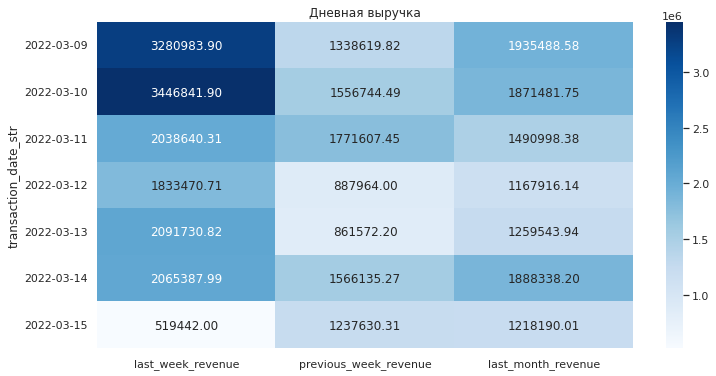

### Метрика 2: Новые пользователи

In [ ]:
# команда для возможности создания повторного SQL запроса при ошибке
# cursor.execute("ROLLBACK")

In [53]:
def telegram_new_users():
  
  '''
  Расчет количества новых пользователей по дням:
  last_week_users - количество новых пользователей за последние 7 дней
  previous_week_users - количество новых пользователей за аналогичные дни прошлой недели
  mean_new_users - среднее количество новых пользователей за аналогичные дни последнего месяца
  '''

  # SQL запрос к БД:
  # находим максимальную дату наблюдений
  query = """
          SELECT max_date
          FROM
            (SELECT TO_DATE(MAX(happened_at), 'YYYY-MM-DD') AS max_date FROM events
            UNION
            SELECT TO_DATE(MAX(transaction_created_at), 'YYYY-MM-DD') AS max_date FROM payments) AS t1
          ORDER BY max_date DESC
          LIMIT 1
          """

  cursor.execute(query)            # делаем запрос
  result = cursor.fetchall()       # запрашиваем все строки, получаем результат в виде списка кортежей

  max_date = result[0][0]  # datetime.date(2022, 3, 15)

  # количество дней, которые выгружаем из БД (последние 4 недели)
  days_range = 27

  # SQL запрос к БД:
  query = f"""
          SELECT
            _user_id AS user_id,
            TO_DATE(MIN(happened_at), 'YYYY-MM-DD') AS first_visit
          FROM events
          GROUP BY
            _user_id
          HAVING
            TO_DATE(MIN(happened_at), 'YYYY-MM-DD') >= TO_DATE('{max_date}', 'YYYY-MM-DD') - interval '{days_range} days'
          """

  cursor.execute(query)            # делаем запрос
  result = cursor.fetchall()       # запрашиваем все строки, получаем результат в виде списка кортежей

  columns = [desc[0] for desc in cursor.description]  # названия колонок возьмем из первого элемента cursor.description

  events = pd.DataFrame(result, columns=columns)  # из списка кортежей сделаем датафрейм
  
  min_date = pd.to_datetime(max_date) + pd.DateOffset(-days_range)
  max_date = pd.to_datetime(max_date)

  # датафрейм с днями из колонки first_visit
  days = pd.DataFrame(pd.date_range(min_date, max_date, freq='D'))
  days.columns = ['first_visit']

  # датафрейм с количеством новых пользователей по дням
  group_events = events.groupby('first_visit', as_index=False).agg({'user_id': 'nunique'})
  group_events['first_visit'] = pd.to_datetime(group_events['first_visit'], format='%Y-%m-%d')

  # объединяем датафреймы days и group_events
  merged_df = pd.merge(days, group_events, on='first_visit', how='left')
  merged_df['user_id'] = merged_df['user_id'].fillna(0)
  merged_df['dow'] = merged_df['first_visit'].dt.day_name()

  # количество новых пользователей за текущую (последнюю) неделю
  last_week = merged_df.first_visit.max() + pd.DateOffset(-6)
  last_week_df = merged_df[merged_df.first_visit >= last_week]
  last_week_df = last_week_df.rename(columns={'user_id': 'last_week_users'})

  # количество новых пользователей за предыдущую неделю
  previous_week = merged_df.first_visit.max() + pd.DateOffset(-13)
  previous_week_df = merged_df[(merged_df.first_visit >= previous_week) & (merged_df.first_visit < last_week)]
  previous_week_df = previous_week_df.rename(columns={'user_id': 'previous_week_users'})
  
  # среднее количество новых пользователей за последние 4 недели
  group_last_month = merged_df.groupby(['dow'], as_index=False).agg({'user_id': 'sum'})
  group_last_month['mean_new_users'] = np.round(group_last_month['user_id'] / 4, 2)  # делим количество пользователей на количество недель (4)
  group_last_month = group_last_month.drop(columns=['user_id'])

  # объединяем созданные датафреймы
  df = last_week_df.merge(previous_week_df[['dow', 'previous_week_users']], on='dow', how='left').merge(group_last_month, on='dow', how='left')

  # перевод колонки first_visit в формат string (для создания heatmap)
  df['first_visit_str'] = df['first_visit'].dt.strftime('%Y-%m-%d')

  # удаляем лишние колонки
  df = df.loc[:, ['first_visit_str', 'last_week_users', 'previous_week_users', 'mean_new_users']]
  # установка колонки transaction_date_str в качестве индекса
  df = df.set_index(['first_visit_str'])

  # создаем heatmap
  plt.subplots(figsize=(12, 6))
  ax = sns.heatmap(df, annot=True, fmt='.2f', cmap="Greens")
  ax.set_title('Количество новых пользователей', fontsize=24)
  plt.savefig('viz.png')  # сохраняем диаграмму в файл

  photo = open('viz.png', 'rb')
  return bot.send_photo(user_id, photo)  # отправляем диаграмму юзеру

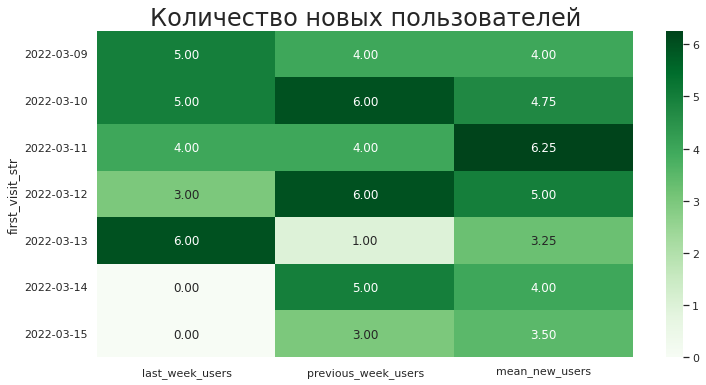

### Метрика 3: Статусы новых пользователей за последние 28 дней

In [ ]:
# команда для возможности создания повторного SQL запроса при ошибке
# cursor.execute("ROLLBACK")

In [54]:
def telegram_new_users_status():

  '''
  Количество новых пользователей за последние 28 дней прошедших разные этапы CJM
  с разбивкой Оплатившие / Все пользователи
  '''
    
  # SQL запрос к БД:
  # находим максимальную дату наблюдений
  query = """
          SELECT max_date
          FROM
            (SELECT TO_DATE(MAX(happened_at), 'YYYY-MM-DD') AS max_date FROM events
            UNION
            SELECT TO_DATE(MAX(transaction_created_at), 'YYYY-MM-DD') AS max_date FROM payments) AS t1
          ORDER BY max_date DESC
          LIMIT 1
          """

  cursor.execute(query)            # делаем запрос
  result = cursor.fetchall()       # запрашиваем все строки, получаем результат в виде списка кортежей

  max_date = result[0][0]  # datetime.date(2022, 3, 15)

  # количество дней, которые выгружаем из БД (последние 4 недели)
  days_range = 27

  # SQL запрос к БД:
  # описание события и количество пользователей
  # прошедших это событие
  query = f"""
          WITH a1 AS (SELECT
                        event_id,
                        COUNT(DISTINCT CASE WHEN _user_id IN (SELECT DISTINCT _user_id FROM payments) THEN _user_id ELSE NULL END) AS n_paid_users,
                        COUNT(DISTINCT _user_id) AS n_users
                      FROM
                        events
                      WHERE
                        _user_id IN (SELECT _user_id
                                    FROM events
                                    GROUP BY _user_id
                                    HAVING TO_DATE(MIN(happened_at), 'YYYY-MM-DD') >= TO_DATE('{max_date}', 'YYYY-MM-DD') - interval '{days_range} days')
                      GROUP BY
                        event_id
                      )

          SELECT _description, n_paid_users, n_users
          FROM events_dict AS t1 LEFT JOIN a1 ON t1.id = a1.event_id
          """

  cursor.execute(query)            # делаем запрос
  result = cursor.fetchall()       # запрашиваем все строки, получаем результат в виде списка кортежей

  columns = [desc[0] for desc in cursor.description]  # названия колонок возьмем из первого элемента cursor.description

  df = pd.DataFrame(result, columns=columns)  # из списка кортежей сделаем датафрейм
  df = df.fillna(0)  # заполняем нулями отсутствующие значения
  df['n_paid_users'] = df['n_paid_users'].astype(int)
  df['n_users'] = df['n_users'].astype(int)
  df.columns = ['Описание', 'Оплатившие пользователи', 'Все пользователи']

  # функция для сохранения датафрейма в png
  def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=12,
                      header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                      bbox=[0, 0, 1, 1], header_columns=0,
                      ax=None, **kwargs):
      if ax is None:
          size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
          fig, ax = plt.subplots(figsize=size)
          ax.axis('off')

      mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
      ax.set_title('Статусы новых пользователей за последние 28 дней', fontsize=24)

      mpl_table.auto_set_font_size(False)
      mpl_table.set_fontsize(font_size)

      for k, cell in  six.iteritems(mpl_table._cells):
          cell.set_edgecolor(edge_color)
          if k[0] == 0 or k[1] < header_columns:
              cell.set_text_props(weight='bold', color='w')
              cell.set_facecolor(header_color)
          else:
              cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
      return plt.savefig('viz.png')

  render_mpl_table(df, header_columns=0, col_width=5.2)

  photo = open('viz.png', 'rb')
  return bot.send_photo(user_id, photo)  # отправляем диаграмму юзеру

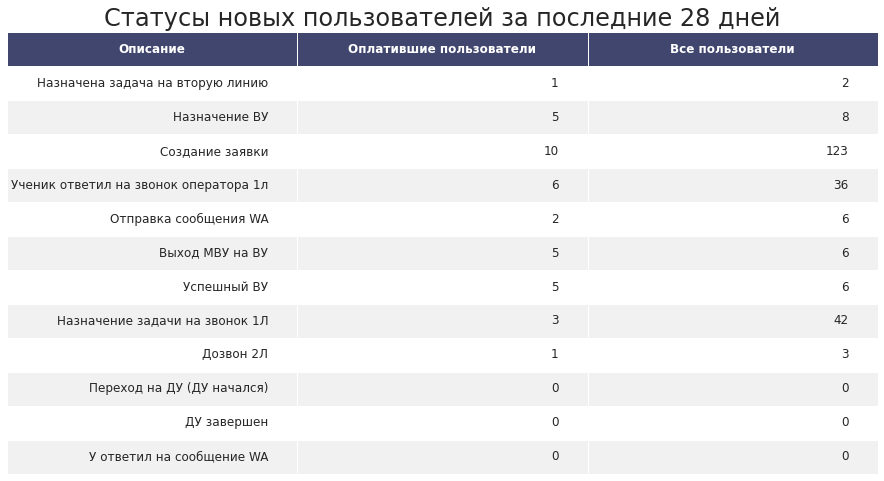

### Отправка диаграмм по расписанию

In [ ]:
# ежедневное время отправки сообщения
# минус 3 часа относительного московского времени
send_time = "17:33"

job_1 = schedule.every().day.at(send_time).do(telegram_revenue)
job_2 = schedule.every().day.at(send_time).do(telegram_new_users)
job_3 = schedule.every().day.at(send_time).do(telegram_new_users_status)

while True:
  schedule.run_pending()
  time.sleep(1)

### Отправка диаграмм по запросу в Telegram

In [57]:
help_message = """
R - Дневная выручка
N - Новые пользователи
S - Статусы новых пользователей
"""

In [58]:
# отправка актуальной диаграммы по запросу
@bot.message_handler(content_types=['text', 'document', 'audio'])
def get_text_messages(message):
  # Отправка дневной выручки
  if message.text == "R":
    telegram_revenue()
  elif message.text == "N":
    telegram_new_users()
  elif message.text == "S":
    telegram_new_users_status()
  elif message.text == "/help":
    bot.send_message(message.from_user.id, help_message)
  else:
    bot.send_message(message.from_user.id, "Я тебя не понимаю. Напиши /help.")

In [59]:
bot.polling(none_stop=True, interval=0)